# Classifier Model to check if the City is New York or London

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
urls = search_images('new york city', max_images=1)
urls[0]

Searching for 'new york city'


'https://upload.wikimedia.org/wikipedia/commons/1/19/Times_Square,_New_York_City_(HDR).jpg'

...and then download a URL and take a look at it:

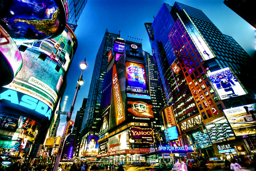

In [4]:
from fastdownload import download_url
dest = 'nyc.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

In [5]:
download_url(search_images('London', max_images=1)[0], 'london.jpg', show_progress=True)
Image.open('london.jpg').to_thumb(256,256)

Searching for 'London'


HTTPError: HTTP Error 410: Gone
====Error Body====
{"response":{"errors":["Image has been removed"]},"body":{"errors":["Image has been removed"]}}

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
path = Path('data')

In [6]:
searches = 'London','New York City'
path = Path('data')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} street photos'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} map photos'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'London photo'
Searching for 'London street photos'
Searching for 'London map photos'


/home/jay/Repos/ml/.venv/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'New York City photo'
Searching for 'New York City street photos'
Searching for 'New York City map photos'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

NameError: name 'path' is not defined

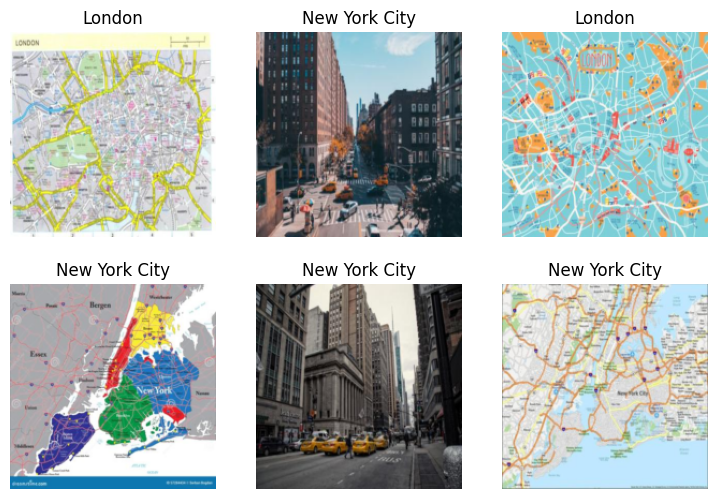

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.180074,2.057743,0.515152,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.700979,1.125478,0.363636,00:13
1,0.489300,1.035513,0.424242,00:11
2,0.404993,1.068687,0.424242,00:10


In [10]:
is_london,_,probs = learn.predict(PILImage.create('london.jpg'))
print(f"This is a: {is_london}.")
print(f"Probability it's a London: {probs[0]:.4f}")

This is a: London.
Probability it's a London: 0.9971


In [11]:
is_nyc, _, probs = learn.predict(PILImage.create('nyc-2.jpg'))
print(f"This is a: {is_nyc}.")
print(f"Probability it's a New York City: {1 - probs[0]:.4f}")

This is a: New York City.
Probability it's a New York City: 0.5158
